Now training with: {'alpha': 0.558532, 'beta': 1.496159, 'n': 3.463616, 'seq_len': 40}
epoch 1 train 0.19746661323240433 val 0.1751578419605891
epoch 2 train 0.17213726482172123 val 0.17032380481561024
epoch 3 train 0.16773737120902402 val 0.16703836687405904
epoch 4 train 0.1638923930025649 val 0.16289279143015545
epoch 5 train 0.15957866468648801 val 0.15869171416759492
epoch 6 train 0.15368719703849704 val 0.1520015013217926
epoch 7 train 0.14563738683174396 val 0.1431936453183492
epoch 8 train 0.13635034033621865 val 0.13427349162101745
epoch 9 train 0.1270260755358071 val 0.12488505858182906
epoch 10 train 0.11794235028069595 val 0.1165937968492508


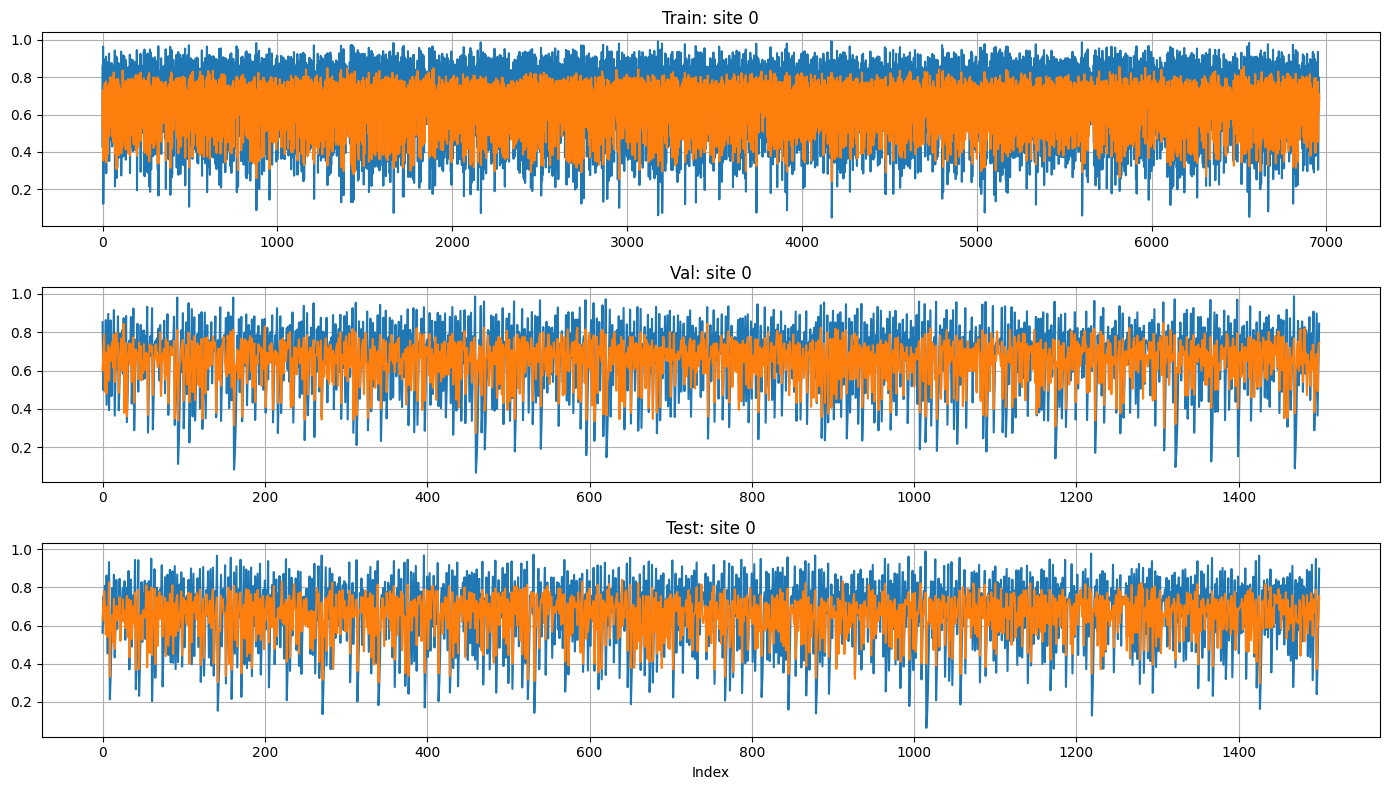

===== GRID SEARCH SUMMARY =====
      alpha      beta         n  seq_len  final_train_loss  final_val_loss  \
0  0.558532  1.496159  3.463616       40          0.117942        0.116594   

   train_rmse  val_rmse  test_rmse     score  
0    0.157746  0.159594   0.159956  0.159956  
Best config by score:
alpha                0.558532
beta                 1.496159
n                    3.463616
seq_len             40.000000
final_train_loss     0.117942
final_val_loss       0.116594
train_rmse           0.157746
val_rmse             0.159594
test_rmse            0.159956
score                0.159956
Name: 0, dtype: float64


In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.nn.init as init
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import os
import random

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class ChebySigmoid(nn.Module):
    def __init__(self, alpha=1.0, beta=1.0, n=1.0):
        super().__init__()
        self.alpha = alpha
        self.beta = beta
        self.n = n
    def forward(self, x):
        s = torch.sigmoid(x)
        tb = torch.tanh(self.beta * x)
        tb = torch.clamp(tb, -1 + 1e-6, 1 - 1e-6)
        return s + self.alpha * torch.cos(self.n * torch.acos(tb)) * s * (1 - s)

class ChebyTanh(nn.Module):
    def __init__(self, alpha=1.0, beta=1.0, n=1.0):
        super().__init__()
        self.alpha = alpha
        self.beta = beta
        self.n = n
    def forward(self, x):
        tb = torch.tanh(self.beta * x)
        tb = torch.clamp(tb, -1 + 1e-6, 1 - 1e-6)
        t = torch.tanh(x)
        sech2 = (1 / torch.cosh(x)) ** 2
        return t + self.alpha * torch.cos(self.n * torch.acos(tb)) * sech2

class ChebyLSTMCell(nn.Module):
    def __init__(self, input_size, hidden_size, alpha=1.0, beta=1.0, n=1.0):
        super().__init__()
        self.hidden_size = hidden_size
        self.w_ih = nn.Parameter(torch.empty(4 * hidden_size, input_size))
        self.w_hh = nn.Parameter(torch.empty(4 * hidden_size, hidden_size))
        self.b_ih = nn.Parameter(torch.zeros(4 * hidden_size))
        self.b_hh = nn.Parameter(torch.zeros(4 * hidden_size))
        self.sig_act = ChebySigmoid(alpha, beta, n)
        self.tanh_act = ChebyTanh(alpha, beta, n)
        init.xavier_uniform_(self.w_ih)
        init.xavier_uniform_(self.w_hh)
    def forward(self, x_t, state):
        h, c = state
        gates = F.linear(x_t, self.w_ih, self.b_ih) + F.linear(h, self.w_hh, self.b_hh)
        i, f, g, o = gates.chunk(4, dim=1)
        i = self.sig_act(i)
        f = self.sig_act(f)
        g = self.tanh_act(g)
        o = self.sig_act(o)
        c_next = f * c + i * g
        h_next = o * self.tanh_act(c_next)
        return h_next, (h_next, c_next)

class ChebyLSTM(nn.Module):
    def __init__(self, input_size, hidden_size=32, output_size=None, alpha=1.0, beta=1.0, n=1.0):
        super().__init__()
        if output_size is None:
            output_size = input_size
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.cell = ChebyLSTMCell(input_size, hidden_size, alpha, beta, n)
        self.fc = nn.Linear(hidden_size, output_size)
        init.xavier_uniform_(self.fc.weight)
        if self.fc.bias is not None:
            init.constant_(self.fc.bias, 0.0)
    def forward(self, x):
        x = x.transpose(0, 1)
        b = x.size(1)
        h = torch.zeros(b, self.hidden_size, device=x.device)
        c = torch.zeros(b, self.hidden_size, device=x.device)
        for t in range(x.size(0)):
            h, (h, c) = self.cell(x[t], (h, c))
        y = self.fc(h)
        return y

def load_coupled_series(csv_path):
    df = pd.read_csv(csv_path)
    if "step" in df.columns:
        df = df.drop(columns=["step"])
    num_df = df.select_dtypes(include=[np.number])
    data = num_df.values.astype(np.float32)
    return data

def make_supervised_multi(data, seq_len):
    T, D = data.shape
    N = T - seq_len
    X = np.zeros((N, seq_len, D), dtype=np.float32)
    Y = np.zeros((N, D), dtype=np.float32)
    for i in range(N):
        X[i] = data[i:i+seq_len]
        Y[i] = data[i+seq_len]
    return X, Y

def prepare_loaders_multi(data, seq_len=20, split=0.7, val_split=0.15, batch=64):
    T = data.shape[0]
    train_end = int(T * split)
    val_end = int(T * (split + val_split))
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler.fit(data[:train_end])
    data_scaled = scaler.transform(data)
    X, Y = make_supervised_multi(data_scaled, seq_len)
    train_N = train_end - seq_len
    val_N = val_end - seq_len
    train_X_np = X[:train_N]
    train_Y_np = Y[:train_N]
    val_X_np = X[train_N:val_N]
    val_Y_np = Y[train_N:val_N]
    test_X_np = X[val_N:]
    test_Y_np = Y[val_N:]
    train_ds = TensorDataset(torch.tensor(train_X_np, dtype=torch.float32, device=device),
                             torch.tensor(train_Y_np, dtype=torch.float32, device=device))
    val_ds = TensorDataset(torch.tensor(val_X_np, dtype=torch.float32, device=device),
                           torch.tensor(val_Y_np, dtype=torch.float32, device=device))
    test_ds = TensorDataset(torch.tensor(test_X_np, dtype=torch.float32, device=device),
                            torch.tensor(test_Y_np, dtype=torch.float32, device=device))
    train_loader = DataLoader(train_ds, batch_size=batch, shuffle=True, drop_last=True)
    val_loader = DataLoader(val_ds, batch_size=batch, shuffle=False, drop_last=False)
    test_loader = DataLoader(test_ds, batch_size=batch, shuffle=False, drop_last=False)
    return train_loader, val_loader, test_loader, scaler, \
           train_X_np, train_Y_np, val_X_np, val_Y_np, test_X_np, test_Y_np

def train_once(model, train_loader, val_loader, epochs=10, lr=1e-3):
    model = model.to(device)
    opt = optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.MSELoss()
    train_losses = []
    val_losses = []
    for ep in range(epochs):
        model.train()
        total = 0.0
        for xb, yb in train_loader:
            opt.zero_grad()
            yhat = model(xb)
            loss = loss_fn(yhat, yb)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
            opt.step()
            total += loss.item() * xb.size(0)
        avg_tr = total / len(train_loader.dataset)
        model.eval()
        tot_val = 0.0
        with torch.no_grad():
            for xb, yb in val_loader:
                yhat = model(xb)
                l = loss_fn(yhat, yb)
                tot_val += l.item() * xb.size(0)
        avg_val = tot_val / max(1, len(val_loader.dataset))
        train_losses.append(avg_tr)
        val_losses.append(avg_val)
        print("epoch", ep + 1, "train", avg_tr, "val", avg_val)
    return model, train_losses, val_losses

def evaluate_rmse(model, X, Y, scaler):
    model.eval()
    X_t = torch.tensor(X, dtype=torch.float32, device=device)
    with torch.no_grad():
        pred = model(X_t).cpu().numpy()
    true = Y
    pred_inv = scaler.inverse_transform(pred)
    true_inv = scaler.inverse_transform(true)
    rmse = np.sqrt(np.mean((pred_inv - true_inv) ** 2))
    return true_inv, pred_inv, rmse

def plot_site_predictions(site_index, train_true, train_pred, val_true, val_pred, test_true, test_pred):
    fig, axes = plt.subplots(3, 1, figsize=(14, 8), sharex=False)

    axes[0].plot(train_true[:, site_index])
    axes[0].plot(train_pred[:, site_index])
    axes[0].set_title("Train: site {}".format(site_index))
    axes[0].grid(True)

    axes[1].plot(val_true[:, site_index])
    axes[1].plot(val_pred[:, site_index])
    axes[1].set_title("Val: site {}".format(site_index))
    axes[1].grid(True)

    axes[2].plot(test_true[:, site_index])
    axes[2].plot(test_pred[:, site_index])
    axes[2].set_title("Test: site {}".format(site_index))
    axes[2].set_xlabel("Index")
    axes[2].grid(True)

    plt.tight_layout()
    plt.show()


if __name__ == "__main__":
    csv_path = "coupled_tent_1d.csv"
    if not os.path.exists(csv_path):
        print("csv not found")
        raise SystemExit(1)

    raw_data = load_coupled_series(csv_path)
    input_size = raw_data.shape[1]

    hyperparameter_sets = []
    for _ in range(1):
        hyperparameter_sets.append({
            "alpha":0.558532 ,
            "beta": 1.496159,
            "n":  3.463616,
            "seq_len": 40
            # "alpha": 0.766 ,
            # "beta": 1.282 ,
            # "n": 2.840,
            # "seq_len": 40
        })

    summary_rows = []

    for hp in hyperparameter_sets:
        print("============================================")
        print("Now training with:", hp)

        seq_len = hp["seq_len"]

        train_loader, val_loader, test_loader, scaler, \
        Xtr, Ytr, Xval, Yval, Xte, Yte = prepare_loaders_multi(
            raw_data,
            seq_len=seq_len,
            split=0.7,
            val_split=0.15,
            batch=64
        )

        model = ChebyLSTM(
            input_size=input_size,
            hidden_size=32,
            output_size=input_size,
            alpha=hp["alpha"],
            beta=hp["beta"],
            n=hp["n"]
        )

        model, train_losses, val_losses = train_once(
            model,
            train_loader,
            val_loader,
            epochs=10,
            lr=1e-3
        )

        train_true, train_pred, train_rmse = evaluate_rmse(model, Xtr, Ytr, scaler)
        val_true, val_pred, val_rmse = evaluate_rmse(model, Xval, Yval, scaler)
        test_true, test_pred, test_rmse = evaluate_rmse(model, Xte, Yte, scaler)

        score = test_rmse

        summary_rows.append({
            "alpha": hp["alpha"],
            "beta": hp["beta"],
            "n": hp["n"],
            "seq_len": seq_len,
            "final_train_loss": train_losses[-1],
            "final_val_loss": val_losses[-1],
            "train_rmse": train_rmse,
            "val_rmse": val_rmse,
            "test_rmse": test_rmse,
            "score": score
        })

        plot_site_predictions(
            site_index=0,
            train_true=train_true,
            train_pred=train_pred,
            val_true=val_true,
            val_pred=val_pred,
            test_true=test_true,
            test_pred=test_pred
        )

    print("===== GRID SEARCH SUMMARY =====")
    df_summary = pd.DataFrame(summary_rows)
    print(df_summary)
    best_idx = df_summary["score"].idxmin()
    best_row = df_summary.loc[best_idx]
    print("Best config by score:")
    print(best_row)


Now training baseline with: {'hidden_size': 32, 'seq_len': 40}
epoch 1 train 0.1863238697764517 val 0.17143647456169128
epoch 2 train 0.16966672491753237 val 0.1680243701140086
epoch 3 train 0.1663541336169188 val 0.1647370391289393
epoch 4 train 0.1629630782138342 val 0.1610427903731664
epoch 5 train 0.15880175349356115 val 0.15677656877040863
epoch 6 train 0.15388133059973005 val 0.15184043673674266
epoch 7 train 0.1482259994265677 val 0.1461061065196991
epoch 8 train 0.1419707062600673 val 0.1400578542550405
epoch 9 train 0.13519638502734832 val 0.13358043386538823
epoch 10 train 0.12881802676737994 val 0.1274231457511584


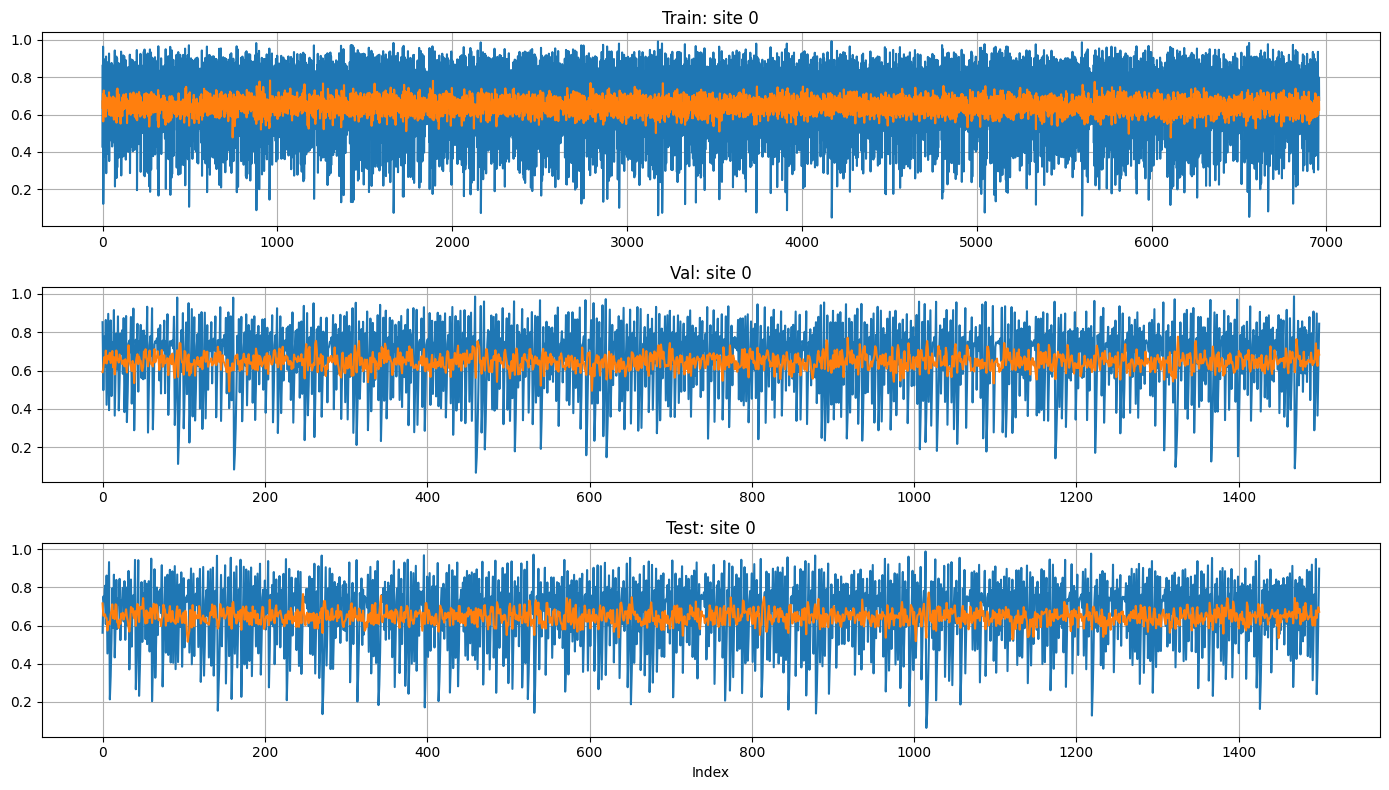

Now training baseline with: {'hidden_size': 64, 'seq_len': 40}
epoch 1 train 0.17924450677016684 val 0.169209690729777
epoch 2 train 0.16686262714451758 val 0.16433290036519368
epoch 3 train 0.16169598678062702 val 0.15938089128335317
epoch 4 train 0.15644066717432834 val 0.15403487428029378
epoch 5 train 0.15018811856193104 val 0.14776180414358775
epoch 6 train 0.14248588249601166 val 0.1396638851563136
epoch 7 train 0.13308642273661733 val 0.13016231874624887
epoch 8 train 0.12293948147488737 val 0.1207843736410141
epoch 9 train 0.11380447053361213 val 0.11261918453375498
epoch 10 train 0.10564761853766168 val 0.10564316719770432


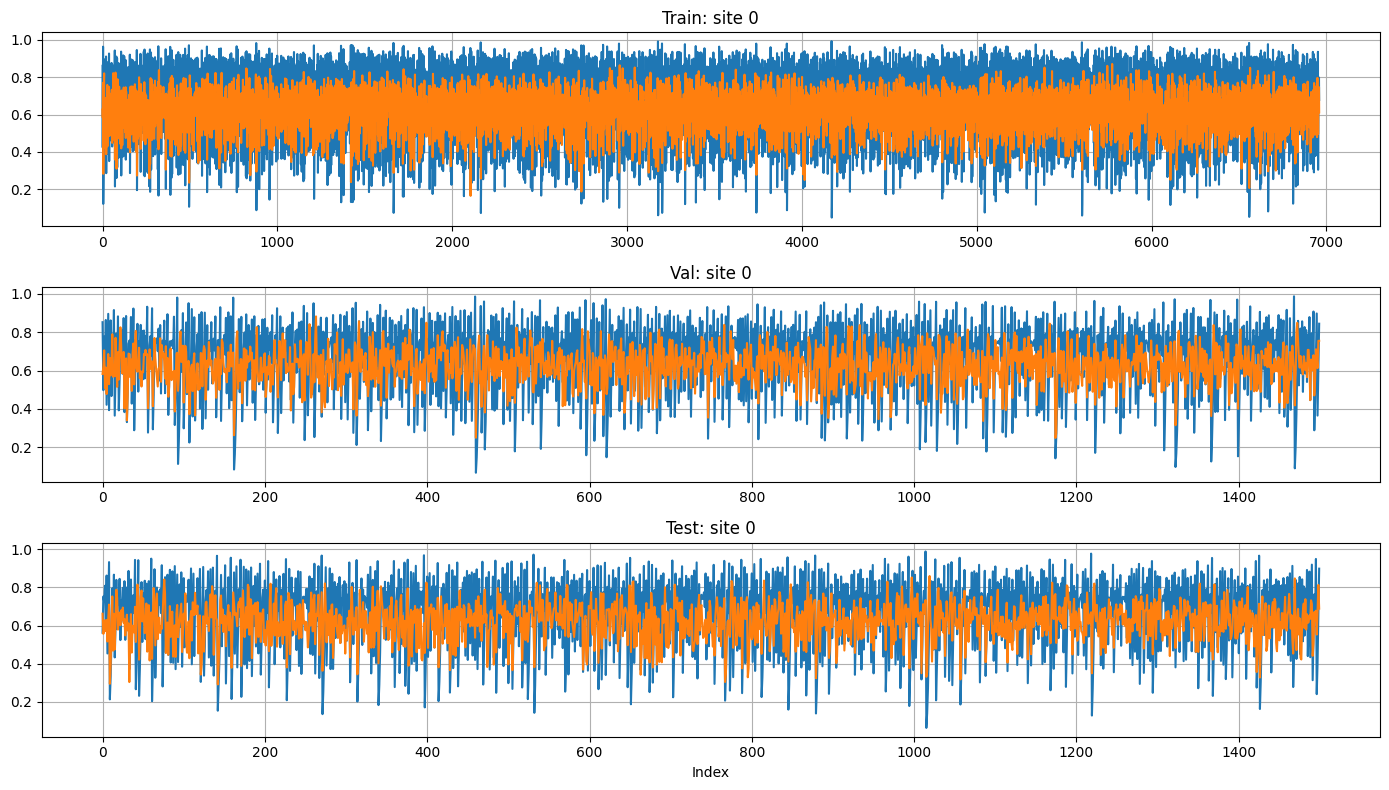

===== BASELINE SUMMARY (max 2 cases) =====
   hidden_size  seq_len  final_train_loss  final_val_loss  train_rmse  \
0           32       40          0.128818        0.127423    0.165867   
1           64       40          0.105648        0.105643    0.149261   

   val_rmse  test_rmse     score  
0  0.166805   0.168438  0.168438  
1  0.151878   0.152730  0.152730  
Best baseline config by score:
hidden_size         64.000000
seq_len             40.000000
final_train_loss     0.105648
final_val_loss       0.105643
train_rmse           0.149261
val_rmse             0.151878
test_rmse            0.152730
score                0.152730
Name: 1, dtype: float64


In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.nn.init as init
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import os

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


class BaselineLSTMCell(nn.Module):
    def __init__(self, input_size, hidden_size):
        super().__init__()
        self.hidden_size = hidden_size
        self.w_ih = nn.Parameter(torch.empty(4 * hidden_size, input_size))
        self.w_hh = nn.Parameter(torch.empty(4 * hidden_size, hidden_size))
        self.b_ih = nn.Parameter(torch.zeros(4 * hidden_size))
        self.b_hh = nn.Parameter(torch.zeros(4 * hidden_size))
        init.xavier_uniform_(self.w_ih)
        init.xavier_uniform_(self.w_hh)

    def forward(self, x_t, state):
        h, c = state
        gates = F.linear(x_t, self.w_ih, self.b_ih) + F.linear(h, self.w_hh, self.b_hh)
        i, f, g, o = gates.chunk(4, dim=1)
        i = torch.sigmoid(i)
        f = torch.sigmoid(f)
        g = torch.tanh(g)
        o = torch.sigmoid(o)
        c_next = f * c + i * g
        h_next = o * torch.tanh(c_next)
        return h_next, (h_next, c_next)


class BaselineLSTM(nn.Module):
    def __init__(self, input_size, hidden_size=32, output_size=None):
        super().__init__()
        if output_size is None:
            output_size = input_size
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.cell = BaselineLSTMCell(input_size, hidden_size)
        self.fc = nn.Linear(hidden_size, output_size)
        init.xavier_uniform_(self.fc.weight)
        if self.fc.bias is not None:
            init.constant_(self.fc.bias, 0.0)

    def forward(self, x):
        x = x.transpose(0, 1)
        b = x.size(1)
        h = torch.zeros(b, self.hidden_size, device=x.device)
        c = torch.zeros(b, self.hidden_size, device=x.device)
        for t in range(x.size(0)):
            h, (h, c) = self.cell(x[t], (h, c))
        y = self.fc(h)
        return y


def load_coupled_series(csv_path):
    df = pd.read_csv(csv_path)
    if "step" in df.columns:
        df = df.drop(columns=["step"])
    num_df = df.select_dtypes(include=[np.number])
    data = num_df.values.astype(np.float32)
    return data


def make_supervised_multi(data, seq_len):
    T, D = data.shape
    N = T - seq_len
    X = np.zeros((N, seq_len, D), dtype=np.float32)
    Y = np.zeros((N, D), dtype=np.float32)
    for i in range(N):
        X[i] = data[i:i + seq_len]
        Y[i] = data[i + seq_len]
    return X, Y


def prepare_loaders_multi(data, seq_len=20, split=0.7, val_split=0.15, batch=64):
    T = data.shape[0]
    train_end = int(T * split)
    val_end = int(T * (split + val_split))
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler.fit(data[:train_end])
    data_scaled = scaler.transform(data)
    X, Y = make_supervised_multi(data_scaled, seq_len)
    train_N = train_end - seq_len
    val_N = val_end - seq_len
    train_X_np = X[:train_N]
    train_Y_np = Y[:train_N]
    val_X_np = X[train_N:val_N]
    val_Y_np = Y[train_N:val_N]
    test_X_np = X[val_N:]
    test_Y_np = Y[val_N:]
    train_ds = TensorDataset(
        torch.tensor(train_X_np, dtype=torch.float32, device=device),
        torch.tensor(train_Y_np, dtype=torch.float32, device=device)
    )
    val_ds = TensorDataset(
        torch.tensor(val_X_np, dtype=torch.float32, device=device),
        torch.tensor(val_Y_np, dtype=torch.float32, device=device)
    )
    test_ds = TensorDataset(
        torch.tensor(test_X_np, dtype=torch.float32, device=device),
        torch.tensor(test_Y_np, dtype=torch.float32, device=device)
    )
    train_loader = DataLoader(train_ds, batch_size=batch, shuffle=True, drop_last=True)
    val_loader = DataLoader(val_ds, batch_size=batch, shuffle=False, drop_last=False)
    test_loader = DataLoader(test_ds, batch_size=batch, shuffle=False, drop_last=False)
    return (
        train_loader,
        val_loader,
        test_loader,
        scaler,
        train_X_np,
        train_Y_np,
        val_X_np,
        val_Y_np,
        test_X_np,
        test_Y_np,
    )


def train_once(model, train_loader, val_loader, epochs=10, lr=1e-3):
    model = model.to(device)
    opt = optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.MSELoss()
    train_losses = []
    val_losses = []
    for ep in range(epochs):
        model.train()
        total = 0.0
        for xb, yb in train_loader:
            opt.zero_grad()
            yhat = model(xb)
            loss = loss_fn(yhat, yb)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
            opt.step()
            total += loss.item() * xb.size(0)
        avg_tr = total / len(train_loader.dataset)
        model.eval()
        tot_val = 0.0
        with torch.no_grad():
            for xb, yb in val_loader:
                yhat = model(xb)
                l = loss_fn(yhat, yb)
                tot_val += l.item() * xb.size(0)
        avg_val = tot_val / max(1, len(val_loader.dataset))
        train_losses.append(avg_tr)
        val_losses.append(avg_val)
        print("epoch", ep + 1, "train", avg_tr, "val", avg_val)
    return model, train_losses, val_losses


def evaluate_rmse(model, X, Y, scaler):
    model.eval()
    X_t = torch.tensor(X, dtype=torch.float32, device=device)
    with torch.no_grad():
        pred = model(X_t).cpu().numpy()
    true = Y
    pred_inv = scaler.inverse_transform(pred)
    true_inv = scaler.inverse_transform(true)
    rmse = float(np.sqrt(np.mean((pred_inv - true_inv) ** 2)))
    return true_inv, pred_inv, rmse


def plot_site_predictions(site_index, train_true, train_pred, val_true, val_pred, test_true, test_pred):
    fig, axes = plt.subplots(3, 1, figsize=(14, 8), sharex=False)
    axes[0].plot(train_true[:, site_index])
    axes[0].plot(train_pred[:, site_index])
    axes[0].set_title("Train: site {}".format(site_index))
    axes[0].grid(True)
    axes[1].plot(val_true[:, site_index])
    axes[1].plot(val_pred[:, site_index])
    axes[1].set_title("Val: site {}".format(site_index))
    axes[1].grid(True)
    axes[2].plot(test_true[:, site_index])
    axes[2].plot(test_pred[:, site_index])
    axes[2].set_title("Test: site {}".format(site_index))
    axes[2].set_xlabel("Index")
    axes[2].grid(True)
    plt.tight_layout()
    plt.show()


if __name__ == "__main__":
    csv_path = "coupled_tent_1d.csv"
    if not os.path.exists(csv_path):
        print("csv not found")
        raise SystemExit(1)

    raw_data = load_coupled_series(csv_path)
    input_size = raw_data.shape[1]

    hyperparameter_sets = [
        {"hidden_size": 32, "seq_len": 40},
        {"hidden_size": 64, "seq_len": 40},
    ]

    summary_rows = []

    for hp in hyperparameter_sets:
        print("============================================")
        print("Now training baseline with:", hp)

        seq_len = hp["seq_len"]
        hidden_size = hp["hidden_size"]

        (
            train_loader,
            val_loader,
            test_loader,
            scaler,
            Xtr,
            Ytr,
            Xval,
            Yval,
            Xte,
            Yte,
        ) = prepare_loaders_multi(
            raw_data,
            seq_len=seq_len,
            split=0.7,
            val_split=0.15,
            batch=64,
        )

        model = BaselineLSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            output_size=input_size,
        )

        model, train_losses, val_losses = train_once(
            model,
            train_loader,
            val_loader,
            epochs=10,
            lr=1e-3,
        )

        train_true, train_pred, train_rmse = evaluate_rmse(model, Xtr, Ytr, scaler)
        val_true, val_pred, val_rmse = evaluate_rmse(model, Xval, Yval, scaler)
        test_true, test_pred, test_rmse = evaluate_rmse(model, Xte, Yte, scaler)

        score = test_rmse

        summary_rows.append({
            "hidden_size": hidden_size,
            "seq_len": seq_len,
            "final_train_loss": train_losses[-1],
            "final_val_loss": val_losses[-1],
            "train_rmse": train_rmse,
            "val_rmse": val_rmse,
            "test_rmse": test_rmse,
            "score": score,
        })

        plot_site_predictions(
            site_index=0,
            train_true=train_true,
            train_pred=train_pred,
            val_true=val_true,
            val_pred=val_pred,
            test_true=test_true,
            test_pred=test_pred,
        )

    print("===== BASELINE SUMMARY (max 2 cases) =====")
    df_summary = pd.DataFrame(summary_rows)
    print(df_summary)
    best_idx = df_summary["score"].idxmin()
    best_row = df_summary.loc[best_idx]
    print("Best baseline config by score:")
    print(best_row)


epoch 1 train 0.1649472269518622 val 0.15075398004055024
epoch 2 train 0.13632892938866012 val 0.12518890047073364
epoch 3 train 0.10814494333047976 val 0.09886750155687332
epoch 4 train 0.08279001438754728 val 0.07826187705993652
epoch 5 train 0.06348064641157786 val 0.06102519876758258
epoch 6 train 0.047471279316935046 val 0.044468556175629295
epoch 7 train 0.03318789197110582 val 0.03128746603926023
epoch 8 train 0.022623880002005346 val 0.02157050167520841
epoch 9 train 0.015788795918911355 val 0.01587102580567201
epoch 10 train 0.0115281715304002 val 0.011964083306491374
Final RMSE Train 0.04503241553902626 Val 0.05113252252340317 Test 0.05208764970302582


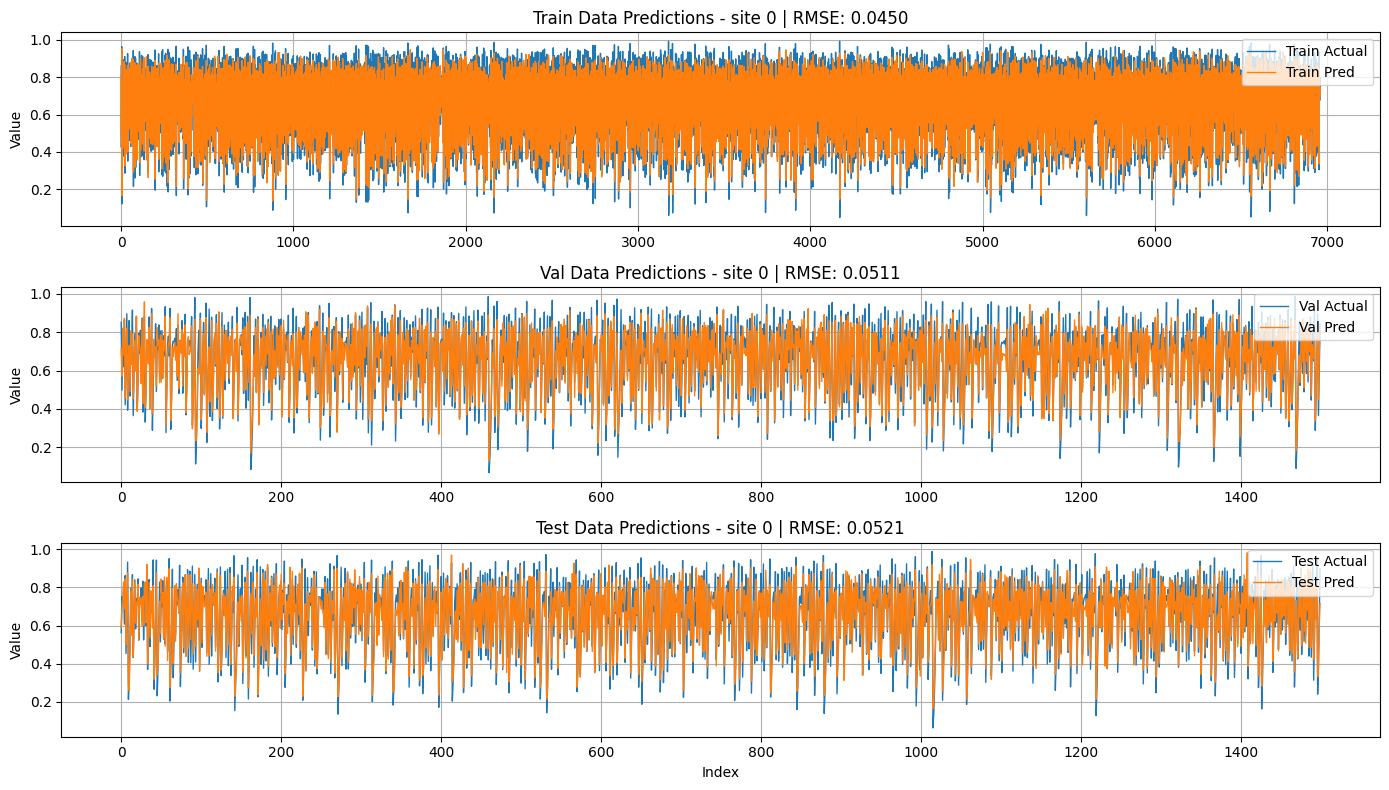

In [4]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.nn.init as init
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import os

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


class ChebySigmoid(nn.Module):
    def __init__(self, alpha=1.0, beta=1.0, n=1.0):
        super().__init__()
        self.alpha = alpha
        self.beta = beta
        self.n = n

    def forward(self, x):
        s = torch.sigmoid(x)
        tb = torch.tanh(self.beta * x)
        tb = torch.clamp(tb, -1 + 1e-6, 1 - 1e-6)
        return s + self.alpha * torch.cos(self.n * torch.acos(tb)) * s * (1 - s)


class ChebyTanh(nn.Module):
    def __init__(self, alpha=1.0, beta=1.0, n=1.0):
        super().__init__()
        self.alpha = alpha
        self.beta = beta
        self.n = n

    def forward(self, x):
        tb = torch.tanh(self.beta * x)
        tb = torch.clamp(tb, -1 + 1e-6, 1 - 1e-6)
        t = torch.tanh(x)
        sech2 = (1.0 / torch.cosh(x)) ** 2
        return t + self.alpha * torch.cos(self.n * torch.acos(tb)) * sech2


class ChebyLSTMCell(nn.Module):
    def __init__(self, input_size, hidden_size, alpha=1.0, beta=1.0, n=1.0):
        super().__init__()
        self.hidden_size = hidden_size
        self.w_ih = nn.Parameter(torch.empty(4 * hidden_size, input_size))
        self.w_hh = nn.Parameter(torch.empty(4 * hidden_size, hidden_size))
        self.b_ih = nn.Parameter(torch.zeros(4 * hidden_size))
        self.b_hh = nn.Parameter(torch.zeros(4 * hidden_size))
        self.sig_act = ChebySigmoid(alpha, beta, n)
        self.tanh_act = ChebyTanh(alpha, beta, n)
        init.xavier_uniform_(self.w_ih)
        init.xavier_uniform_(self.w_hh)

    def forward(self, x_t, state):
        h, c = state
        gates = F.linear(x_t, self.w_ih, self.b_ih) + F.linear(h, self.w_hh, self.b_hh)
        i, f, g, o = gates.chunk(4, dim=1)
        i = self.sig_act(i)
        f = self.sig_act(f)
        g = self.tanh_act(g)
        o = self.sig_act(o)
        c_next = f * c + i * g
        h_next = o * self.tanh_act(c_next)
        return h_next, (h_next, c_next)


class ChebyLSTM(nn.Module):
    def __init__(self, input_size, hidden_size=32, output_size=None, alpha=1.0, beta=1.0, n=1.0):
        super().__init__()
        if output_size is None:
            output_size = input_size
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.cell = ChebyLSTMCell(input_size, hidden_size, alpha, beta, n)
        self.fc = nn.Linear(hidden_size, output_size)
        init.xavier_uniform_(self.fc.weight)
        if self.fc.bias is not None:
            init.constant_(self.fc.bias, 0.0)

    def forward(self, x):
        x = x.transpose(0, 1)
        b = x.size(1)
        h = torch.zeros(b, self.hidden_size, device=x.device)
        c = torch.zeros(b, self.hidden_size, device=x.device)
        for t in range(x.size(0)):
            h, (h, c) = self.cell(x[t], (h, c))
        y = self.fc(h)
        return y


def load_coupled_series(csv_path):
    df = pd.read_csv(csv_path)
    if "step" in df.columns:
        df = df.drop(columns=["step"])
    num_df = df.select_dtypes(include=[np.number])
    data = num_df.values.astype(np.float32)
    return data


def make_supervised_multi(data, seq_len):
    T, D = data.shape
    N = T - seq_len
    X = np.zeros((N, seq_len, D), dtype=np.float32)
    Y = np.zeros((N, D), dtype=np.float32)
    for i in range(N):
        X[i] = data[i:i + seq_len]
        Y[i] = data[i + seq_len]
    return X, Y


def prepare_loaders_multi(data, seq_len=20, split=0.7, val_split=0.15, batch=64):
    T = data.shape[0]
    train_end = int(T * split)
    val_end = int(T * (split + val_split))
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler.fit(data[:train_end])
    data_scaled = scaler.transform(data)
    X, Y = make_supervised_multi(data_scaled, seq_len)
    train_N = train_end - seq_len
    val_N = val_end - seq_len
    train_X_np = X[:train_N]
    train_Y_np = Y[:train_N]
    val_X_np = X[train_N:val_N]
    val_Y_np = Y[train_N:val_N]
    test_X_np = X[val_N:]
    test_Y_np = Y[val_N:]
    train_ds = TensorDataset(
        torch.tensor(train_X_np, dtype=torch.float32, device=device),
        torch.tensor(train_Y_np, dtype=torch.float32, device=device)
    )
    val_ds = TensorDataset(
        torch.tensor(val_X_np, dtype=torch.float32, device=device),
        torch.tensor(val_Y_np, dtype=torch.float32, device=device)
    )
    test_ds = TensorDataset(
        torch.tensor(test_X_np, dtype=torch.float32, device=device),
        torch.tensor(test_Y_np, dtype=torch.float32, device=device)
    )
    train_loader = DataLoader(train_ds, batch_size=batch, shuffle=True, drop_last=True)
    val_loader = DataLoader(val_ds, batch_size=batch, shuffle=False, drop_last=False)
    test_loader = DataLoader(test_ds, batch_size=batch, shuffle=False, drop_last=False)
    return (
        train_loader,
        val_loader,
        test_loader,
        scaler,
        train_X_np,
        train_Y_np,
        val_X_np,
        val_Y_np,
        test_X_np,
        test_Y_np,
        data_scaled
    )


def train_once(model, train_loader, val_loader, epochs=10, lr=1e-3):
    model = model.to(device)
    opt = optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.MSELoss()
    train_losses = []
    val_losses = []
    for ep in range(epochs):
        model.train()
        total = 0.0
        for xb, yb in train_loader:
            opt.zero_grad()
            yhat = model(xb)
            loss = loss_fn(yhat, yb)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
            opt.step()
            total += loss.item() * xb.size(0)
        avg_tr = total / len(train_loader.dataset)
        model.eval()
        tot_val = 0.0
        with torch.no_grad():
            for xb, yb in val_loader:
                yhat = model(xb)
                l = loss_fn(yhat, yb)
                tot_val += l.item() * xb.size(0)
        avg_val = tot_val / max(1, len(val_loader.dataset))
        train_losses.append(avg_tr)
        val_losses.append(avg_val)
        print("epoch", ep + 1, "train", avg_tr, "val", avg_val)
    return model, train_losses, val_losses


def evaluate_rmse(model, X, Y, scaler):
    model.eval()
    X_t = torch.tensor(X, dtype=torch.float32, device=device)
    with torch.no_grad():
        pred = model(X_t).cpu().numpy()
    true = Y
    pred_inv = scaler.inverse_transform(pred)
    true_inv = scaler.inverse_transform(true)
    rmse = float(np.sqrt(np.mean((pred_inv - true_inv) ** 2)))
    return true_inv, pred_inv, rmse


def plot_site_predictions(site_index, train_true, train_pred, val_true, val_pred, test_true, test_pred, train_rmse, val_rmse, test_rmse):
    fig, axes = plt.subplots(3, 1, figsize=(14, 8), sharex=False)
    axes[0].plot(train_true[:, site_index], linewidth=1, label="Train Actual")
    axes[0].plot(train_pred[:, site_index], linewidth=1, label="Train Pred")
    axes[0].set_title(f"Train Data Predictions - site {site_index} | RMSE: {train_rmse:.4f}")
    axes[0].set_ylabel("Value")
    axes[0].grid(True)
    axes[0].legend(loc="upper right")
    axes[1].plot(val_true[:, site_index], linewidth=1, label="Val Actual")
    axes[1].plot(val_pred[:, site_index], linewidth=1, label="Val Pred")
    axes[1].set_title(f"Val Data Predictions - site {site_index} | RMSE: {val_rmse:.4f}")
    axes[1].set_ylabel("Value")
    axes[1].grid(True)
    axes[1].legend(loc="upper right")
    axes[2].plot(test_true[:, site_index], linewidth=1, label="Test Actual")
    axes[2].plot(test_pred[:, site_index], linewidth=1, label="Test Pred")
    axes[2].set_title(f"Test Data Predictions - site {site_index} | RMSE: {test_rmse:.4f}")
    axes[2].set_xlabel("Index")
    axes[2].set_ylabel("Value")
    axes[2].grid(True)
    axes[2].legend(loc="upper right")
    plt.tight_layout()
    plt.show()


if __name__ == "__main__":
    csv_path = "coupled_tent_1d.csv"
    if not os.path.exists(csv_path):
        print("csv not found")
        raise SystemExit(1)

    raw_data = load_coupled_series(csv_path)

    alpha = 0.558532
    beta = 1.496159
    n = 3.463616
    hidden_size = 256
    seq_len = 40

    (
        train_loader,
        val_loader,
        test_loader,
        scaler,
        Xtr,
        Ytr,
        Xval,
        Yval,
        Xte,
        Yte,
        data_scaled
    ) = prepare_loaders_multi(
        raw_data,
        seq_len=seq_len,
        split=0.7,
        val_split=0.15,
        batch=64,
    )

    input_size = raw_data.shape[1]

    final_model = ChebyLSTM(
        input_size=input_size,
        hidden_size=hidden_size,
        output_size=input_size,
        alpha=alpha,
        beta=beta,
        n=n,
    )

    final_model, train_losses, val_losses = train_once(
        final_model,
        train_loader,
        val_loader,
        epochs=10,
        lr=1e-3,
    )

    train_true, train_pred, train_rmse = evaluate_rmse(final_model, Xtr, Ytr, scaler)
    val_true, val_pred, val_rmse = evaluate_rmse(final_model, Xval, Yval, scaler)
    test_true, test_pred, test_rmse = evaluate_rmse(final_model, Xte, Yte, scaler)

    print("Final RMSE Train", train_rmse, "Val", val_rmse, "Test", test_rmse)

    plot_site_predictions(
        site_index=0,
        train_true=train_true,
        train_pred=train_pred,
        val_true=val_true,
        val_pred=val_pred,
        test_true=test_true,
        test_pred=test_pred,
        train_rmse=train_rmse,
        val_rmse=val_rmse,
        test_rmse=test_rmse,
    )



========== Case1_h64_s20 ==========
epoch 1 train 0.17986240755862698 val 0.1690208760499954
epoch 2 train 0.16706299412899508 val 0.16393367691834768
epoch 3 train 0.16204197987444421 val 0.15850479845205942
epoch 4 train 0.15657860679407856 val 0.15399415481090545
epoch 5 train 0.15031115755993862 val 0.1466489700873693
epoch 6 train 0.1426321710078286 val 0.13838694814840952
epoch 7 train 0.13352685165951791 val 0.12999904314676922
epoch 8 train 0.12429826122983478 val 0.12106236523389816
epoch 9 train 0.11585302605669956 val 0.11301924773057302
epoch 10 train 0.10767486450665319 val 0.10600637759764989
Case1_h64_s20 RMSE -> Train: 0.15048335492610931 Val: 0.15219223499298096 Test: 0.15384583175182343


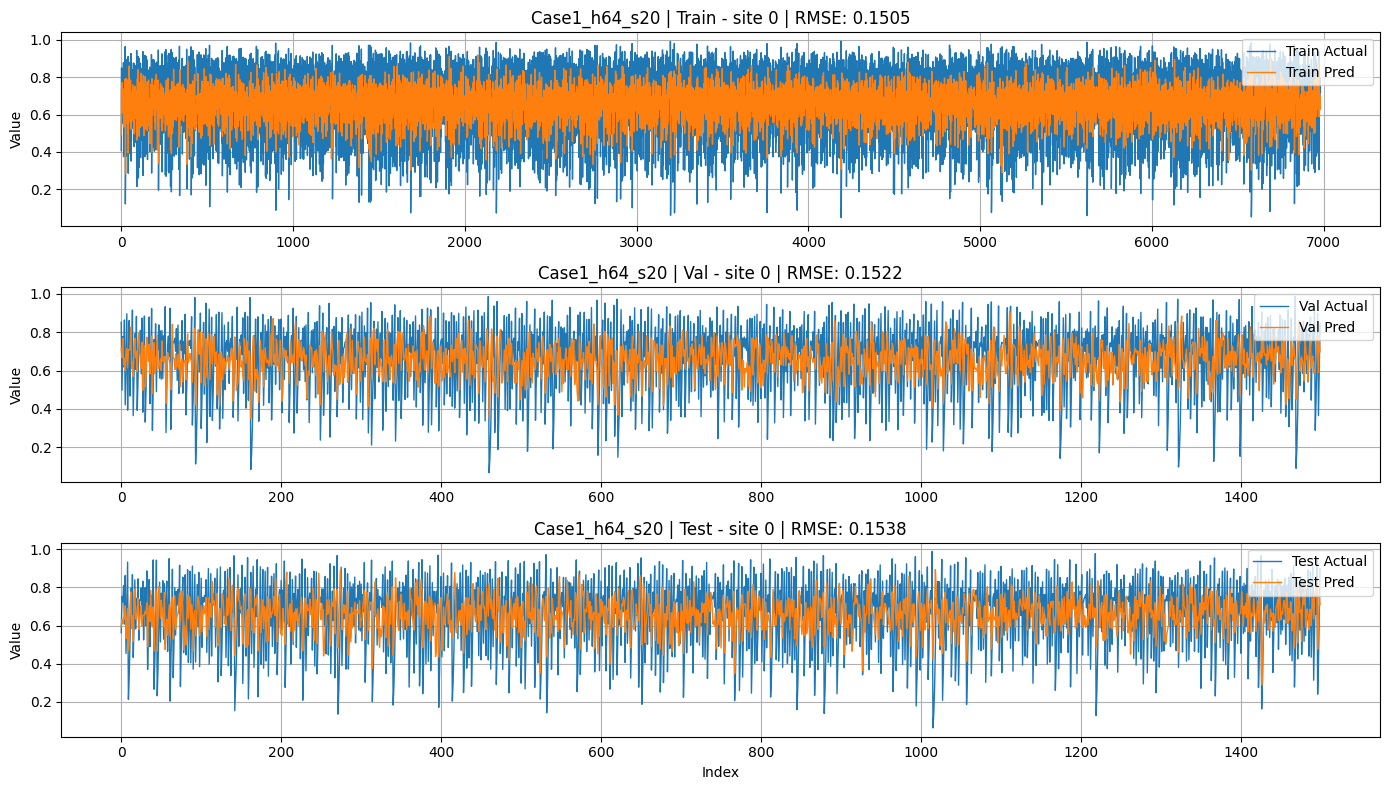


========== Case2_h128_s40 ==========
epoch 1 train 0.17449131162687279 val 0.16644363764921824
epoch 2 train 0.16257900013320747 val 0.1590628278652827
epoch 3 train 0.15525936271952487 val 0.1525543970266978
epoch 4 train 0.1476193177288976 val 0.1444857342640559
epoch 5 train 0.13702741751725647 val 0.13475434084733326
epoch 6 train 0.12421496859912215 val 0.12261611821254094
epoch 7 train 0.11101571725702834 val 0.11043231825033824
epoch 8 train 0.09909597840802423 val 0.10036528565486272
epoch 9 train 0.08859989053901585 val 0.09041254868110021
epoch 10 train 0.08008442726628534 val 0.08256388694047928
Case2_h128_s40 RMSE -> Train: 0.12802988290786743 Val: 0.13423225283622742 Test: 0.13477201759815216


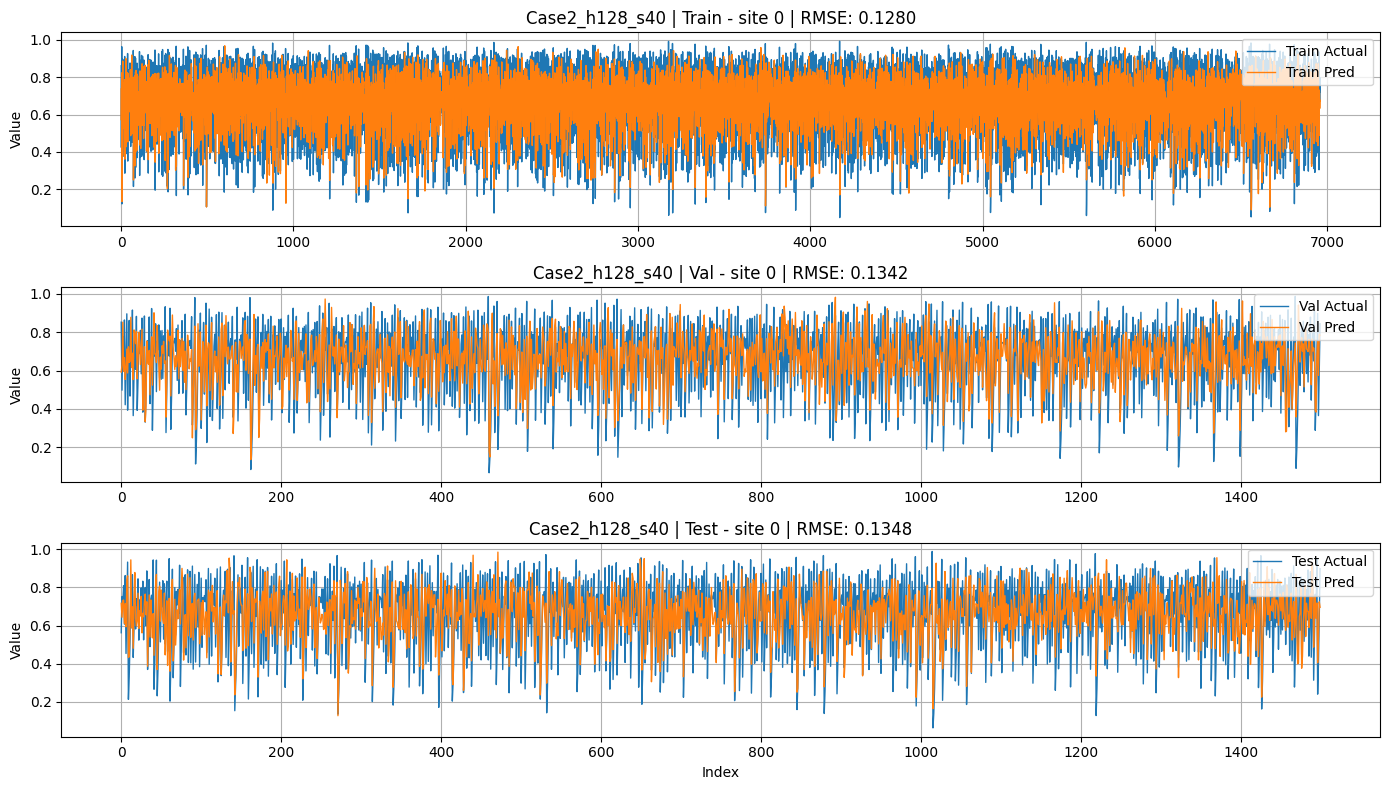


========== Case3_h256_s40 ==========
epoch 1 train 0.1717887389248815 val 0.16315191721916197
epoch 2 train 0.15829580268640628 val 0.15487764195601145
epoch 3 train 0.149593500433297 val 0.1465578109025955
epoch 4 train 0.13792081605428938 val 0.13286423408985137
epoch 5 train 0.1199601041174483 val 0.11591355822483698
epoch 6 train 0.10081421787711396 val 0.0996667713522911
epoch 7 train 0.08534594308370831 val 0.08728769467274348
epoch 8 train 0.07369785336242325 val 0.07791946059465409
epoch 9 train 0.06455482648706984 val 0.07085558585325877
epoch 10 train 0.0577672619244148 val 0.0644869150519371
Case3_h256_s40 RMSE -> Train: 0.10765590518712997 Val: 0.11869107186794281 Test: 0.11874180287122726


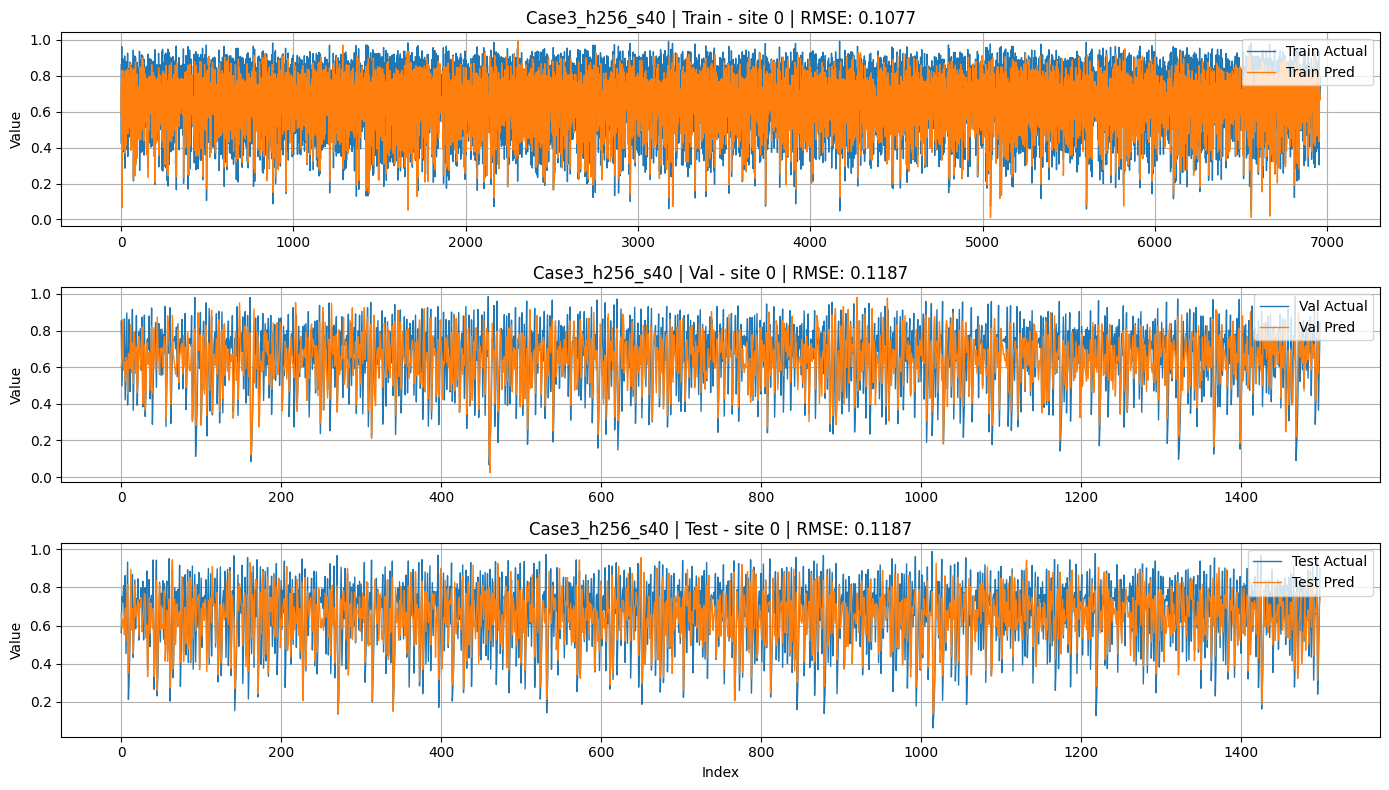


========== Case4_h128_s60 ==========
epoch 1 train 0.17568101305782965 val 0.1668720862865448
epoch 2 train 0.16298335938357483 val 0.15909842149416606
epoch 3 train 0.1550802974261193 val 0.15176480495929717
epoch 4 train 0.14672492780328142 val 0.14312397865454357
epoch 5 train 0.13546902666174368 val 0.13231271135807038
epoch 6 train 0.12184187191020515 val 0.11873852394024531
epoch 7 train 0.107673053233012 val 0.10640116900205612
epoch 8 train 0.09561174396822707 val 0.095975233455499
epoch 9 train 0.0861709207897571 val 0.08769390374422073
epoch 10 train 0.07827478918630726 val 0.08053842367728552
Case4_h128_s60 RMSE -> Train: 0.12721824645996094 Val: 0.13266918063163757 Test: 0.1329961121082306


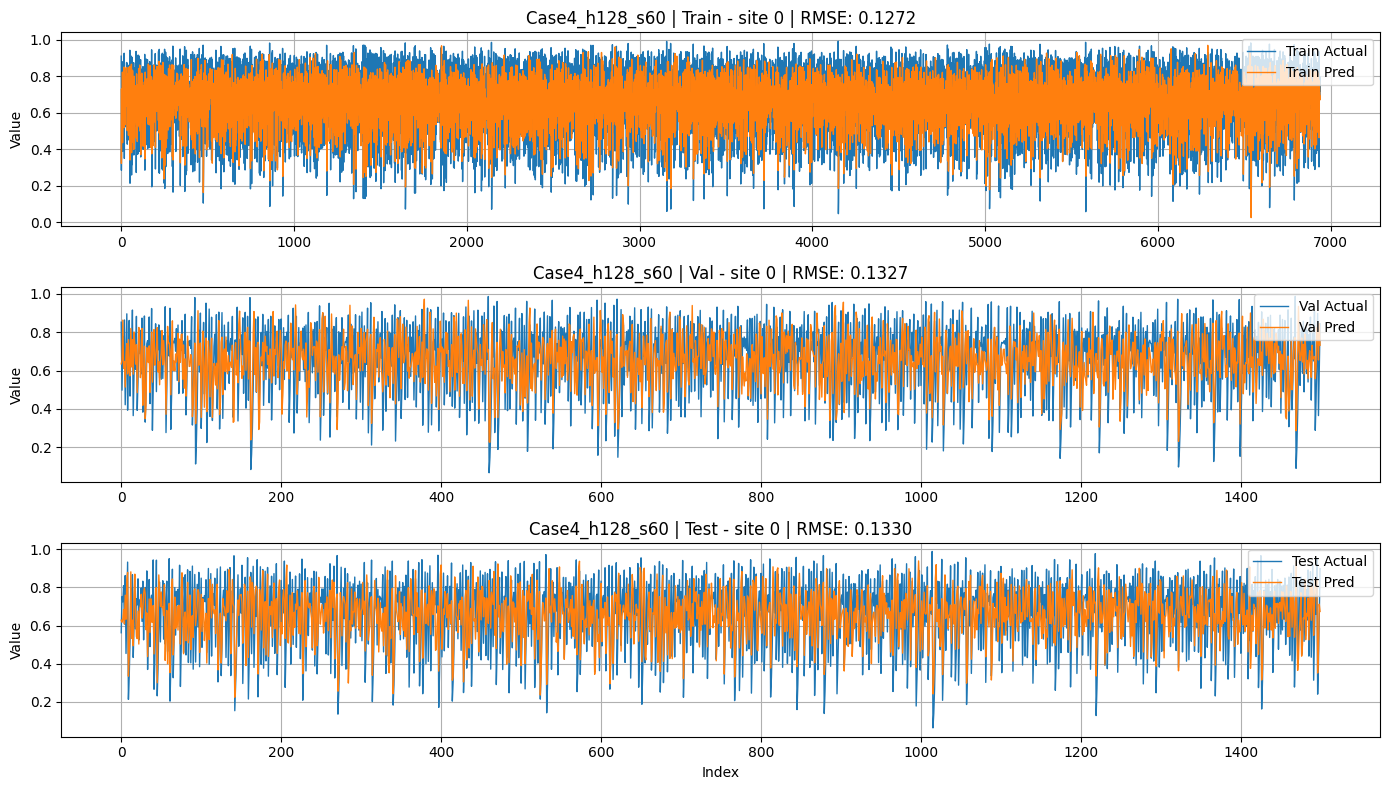

Case4_h128_s60 RMSE -> Train: 0.04503273218870163 Val: 0.05113251879811287 Test: 0.05208764970302582 | W1 -> Train: 0.01742547721369192 Val: 0.01939134596614167 Test: 0.019348516449099407


In [5]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.nn.init as init
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import os

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


class BaselineLSTMCell(nn.Module):
    def __init__(self, input_size, hidden_size):
        super().__init__()
        self.hidden_size = hidden_size
        self.w_ih = nn.Parameter(torch.empty(4 * hidden_size, input_size))
        self.w_hh = nn.Parameter(torch.empty(4 * hidden_size, hidden_size))
        self.b_ih = nn.Parameter(torch.zeros(4 * hidden_size))
        self.b_hh = nn.Parameter(torch.zeros(4 * hidden_size))
        init.xavier_uniform_(self.w_ih)
        init.xavier_uniform_(self.w_hh)

    def forward(self, x_t, state):
        h, c = state
        gates = F.linear(x_t, self.w_ih, self.b_ih) + F.linear(h, self.w_hh, self.b_hh)
        i, f, g, o = gates.chunk(4, dim=1)
        i = torch.sigmoid(i)
        f = torch.sigmoid(f)
        g = torch.tanh(g)
        o = torch.sigmoid(o)
        c_next = f * c + i * g
        h_next = o * torch.tanh(c_next)
        return h_next, (h_next, c_next)


class BaselineLSTM(nn.Module):
    def __init__(self, input_size, hidden_size=32, output_size=None):
        super().__init__()
        if output_size is None:
            output_size = input_size
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.cell = BaselineLSTMCell(input_size, hidden_size)
        self.fc = nn.Linear(hidden_size, output_size)
        init.xavier_uniform_(self.fc.weight)
        if self.fc.bias is not None:
            init.constant_(self.fc.bias, 0.0)

    def forward(self, x):
        x = x.transpose(0, 1)
        b = x.size(1)
        h = torch.zeros(b, self.hidden_size, device=x.device)
        c = torch.zeros(b, self.hidden_size, device=x.device)
        for t in range(x.size(0)):
            h, (h, c) = self.cell(x[t], (h, c))
        y = self.fc(h)
        return y


def load_coupled_series(csv_path):
    df = pd.read_csv(csv_path)
    if "step" in df.columns:
        df = df.drop(columns=["step"])
    num_df = df.select_dtypes(include=[np.number])
    data = num_df.values.astype(np.float32)
    return data


def make_supervised_multi(data, seq_len):
    T, D = data.shape
    N = T - seq_len
    X = np.zeros((N, seq_len, D), dtype=np.float32)
    Y = np.zeros((N, D), dtype=np.float32)
    for i in range(N):
        X[i] = data[i:i + seq_len]
        Y[i] = data[i + seq_len]
    return X, Y


def prepare_loaders_multi(data, seq_len=20, split=0.7, val_split=0.15, batch=64):
    T = data.shape[0]
    train_end = int(T * split)
    val_end = int(T * (split + val_split))
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler.fit(data[:train_end])
    data_scaled = scaler.transform(data)
    X, Y = make_supervised_multi(data_scaled, seq_len)
    train_N = train_end - seq_len
    val_N = val_end - seq_len
    train_X_np = X[:train_N]
    train_Y_np = Y[:train_N]
    val_X_np = X[train_N:val_N]
    val_Y_np = Y[train_N:val_N]
    test_X_np = X[val_N:]
    test_Y_np = Y[val_N:]
    train_ds = TensorDataset(
        torch.tensor(train_X_np, dtype=torch.float32, device=device),
        torch.tensor(train_Y_np, dtype=torch.float32, device=device)
    )
    val_ds = TensorDataset(
        torch.tensor(val_X_np, dtype=torch.float32, device=device),
        torch.tensor(val_Y_np, dtype=torch.float32, device=device)
    )
    test_ds = TensorDataset(
        torch.tensor(test_X_np, dtype=torch.float32, device=device),
        torch.tensor(test_Y_np, dtype=torch.float32, device=device)
    )
    train_loader = DataLoader(train_ds, batch_size=batch, shuffle=True, drop_last=True)
    val_loader = DataLoader(val_ds, batch_size=batch, shuffle=False, drop_last=False)
    test_loader = DataLoader(test_ds, batch_size=batch, shuffle=False, drop_last=False)
    return (
        train_loader,
        val_loader,
        test_loader,
        scaler,
        train_X_np,
        train_Y_np,
        val_X_np,
        val_Y_np,
        test_X_np,
        test_Y_np,
        data_scaled
    )


def train_once(model, train_loader, val_loader, epochs=10, lr=1e-3):
    model = model.to(device)
    opt = optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.MSELoss()
    train_losses = []
    val_losses = []
    for ep in range(epochs):
        model.train()
        total = 0.0
        for xb, yb in train_loader:
            opt.zero_grad()
            yhat = model(xb)
            loss = loss_fn(yhat, yb)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
            opt.step()
            total += loss.item() * xb.size(0)
        avg_tr = total / len(train_loader.dataset)
        model.eval()
        tot_val = 0.0
        with torch.no_grad():
            for xb, yb in val_loader:
                yhat = model(xb)
                l = loss_fn(yhat, yb)
                tot_val += l.item() * xb.size(0)
        avg_val = tot_val / max(1, len(val_loader.dataset))
        train_losses.append(avg_tr)
        val_losses.append(avg_val)
        print("epoch", ep + 1, "train", avg_tr, "val", avg_val)
    return model, train_losses, val_losses


def evaluate_rmse(model, X, Y, scaler):
    model.eval()
    X_t = torch.tensor(X, dtype=torch.float32, device=device)
    with torch.no_grad():
        pred = model(X_t).cpu().numpy()
    true = Y
    pred_inv = scaler.inverse_transform(pred)
    true_inv = scaler.inverse_transform(true)
    rmse = float(np.sqrt(np.mean((pred_inv - true_inv) ** 2)))
    return true_inv, pred_inv, rmse


def plot_site_predictions(site_index, train_true, train_pred, val_true, val_pred, test_true, test_pred, train_rmse, val_rmse, test_rmse, title_prefix=""):
    fig, axes = plt.subplots(3, 1, figsize=(14, 8), sharex=False)
    axes[0].plot(train_true[:, site_index], linewidth=1, label="Train Actual")
    axes[0].plot(train_pred[:, site_index], linewidth=1, label="Train Pred")
    axes[0].set_title(f"{title_prefix}Train - site {site_index} | RMSE: {train_rmse:.4f}")
    axes[0].set_ylabel("Value")
    axes[0].grid(True)
    axes[0].legend(loc="upper right")
    axes[1].plot(val_true[:, site_index], linewidth=1, label="Val Actual")
    axes[1].plot(val_pred[:, site_index], linewidth=1, label="Val Pred")
    axes[1].set_title(f"{title_prefix}Val - site {site_index} | RMSE: {val_rmse:.4f}")
    axes[1].set_ylabel("Value")
    axes[1].grid(True)
    axes[1].legend(loc="upper right")
    axes[2].plot(test_true[:, site_index], linewidth=1, label="Test Actual")
    axes[2].plot(test_pred[:, site_index], linewidth=1, label="Test Pred")
    axes[2].set_title(f"{title_prefix}Test - site {site_index} | RMSE: {test_rmse:.4f}")
    axes[2].set_xlabel("Index")
    axes[2].set_ylabel("Value")
    axes[2].grid(True)
    axes[2].legend(loc="upper right")
    plt.tight_layout()
    plt.show()


def wasserstein_distance_1d(u, v):
    u = np.sort(u.ravel())
    v = np.sort(v.ravel())
    n = u.size
    m = v.size
    i = j = 0
    cdf_u = 0.0
    cdf_v = 0.0
    prev_x = min(u[0], v[0])
    wd = 0.0

    while i < n and j < m:
        if u[i] <= v[j]:
            x = u[i]
            i += 1
            cdf_u = i / n
        else:
            x = v[j]
            j += 1
            cdf_v = j / m
        wd += abs(cdf_u - cdf_v) * (x - prev_x)
        prev_x = x

    while i < n:
        x = u[i]
        i += 1
        cdf_u = i / n
        wd += abs(cdf_u - cdf_v) * (x - prev_x)
        prev_x = x

    while j < m:
        x = v[j]
        j += 1
        cdf_v = j / m
        wd += abs(cdf_u - cdf_v) * (x - prev_x)
        prev_x = x

    return float(wd)


def evaluate_rmse_wasserstein(model, X, Y, scaler):
    model.eval()
    X_t = torch.tensor(X, dtype=torch.float32, device=device)
    with torch.no_grad():
        pred = model(X_t).cpu().numpy()

    pred_inv = scaler.inverse_transform(pred)
    true_inv = scaler.inverse_transform(Y)

    rmse = float(np.sqrt(np.mean((pred_inv - true_inv) ** 2)))

    D = true_inv.shape[1]
    ws_per_site = []
    for d in range(D):
        ws_d = wasserstein_distance_1d(true_inv[:, d], pred_inv[:, d])
        ws_per_site.append(ws_d)
    ws_per_site = np.array(ws_per_site, dtype=np.float64)
    ws_mean = float(ws_per_site.mean())

    return true_inv, pred_inv, rmse, ws_mean, ws_per_site


if __name__ == "__main__":
    csv_path = "coupled_tent_1d.csv"
    if not os.path.exists(csv_path):
        print("csv not found")
        raise SystemExit(1)

    raw_data = load_coupled_series(csv_path)
    input_size = raw_data.shape[1]

    cases = [
        {"name": "Case1_h64_s20", "hidden_size": 64, "seq_len": 20},
        {"name": "Case2_h128_s40", "hidden_size": 128, "seq_len": 40},
        {"name": "Case3_h256_s40", "hidden_size": 256, "seq_len": 40},
        {"name": "Case4_h128_s60", "hidden_size": 128, "seq_len": 60},
    ]

    for cfg in cases:
        print("\n==========", cfg["name"], "==========")
        seq_len = cfg["seq_len"]
        hidden_size = cfg["hidden_size"]

        (
            train_loader,
            val_loader,
            test_loader,
            scaler,
            Xtr,
            Ytr,
            Xval,
            Yval,
            Xte,
            Yte,
            data_scaled
        ) = prepare_loaders_multi(
            raw_data,
            seq_len=seq_len,
            split=0.7,
            val_split=0.15,
            batch=64,
        )

        model = BaselineLSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            output_size=input_size,
        )

        model, train_losses, val_losses = train_once(
            model,
            train_loader,
            val_loader,
            epochs=10,
            lr=1e-3,
        )

        train_true, train_pred, train_rmse, train_ws_mean, train_ws_sites = evaluate_rmse_wasserstein(
            model, Xtr, Ytr, scaler
        )
        val_true, val_pred, val_rmse, val_ws_mean, val_ws_sites = evaluate_rmse_wasserstein(
            model, Xval, Yval, scaler
        )
        test_true, test_pred, test_rmse, test_ws_mean, test_ws_sites = evaluate_rmse_wasserstein(
            model, Xte, Yte, scaler
        )

        print(
            cfg["name"],
            "RMSE -> Train:", train_rmse, "Val:", val_rmse, "Test:", test_rmse,
            "| W1 -> Train:", train_ws_mean, "Val:", val_ws_mean, "Test:", test_ws_mean,
        )

        plot_site_predictions(
            site_index=0,
            train_true=train_true,
            train_pred=train_pred,
            val_true=val_true,
            val_pred=val_pred,
            test_true=test_true,
            test_pred=test_pred,
            train_rmse=train_rmse,
            val_rmse=val_rmse,
            test_rmse=test_rmse,
            title_prefix=cfg["name"] + " | ",
        )




epoch 1 train 0.16593199283227153 val 0.15079311442375182
epoch 2 train 0.1358739109559991 val 0.12464572618405025
epoch 3 train 0.10633372239682866 val 0.09738892473777135
epoch 4 train 0.0807579263873484 val 0.0758000180919965
epoch 5 train 0.06129162095744034 val 0.05859199197093646
epoch 6 train 0.04558456077657897 val 0.04272148814797402
epoch 7 train 0.031602361849669754 val 0.02918372499446074
epoch 8 train 0.021214185295433834 val 0.0201501777023077
epoch 9 train 0.01452342150197632 val 0.014402327219645182
epoch 10 train 0.010471434942607221 val 0.01099124641964833
Final metrics:
Train  RMSE: 0.04307007044553757 W1_mean: 0.016236721130553633
Val    RMSE: 0.04896411672234535 W1_mean: 0.01781954921898432
Test   RMSE: 0.049462780356407166 W1_mean: 0.017912121635163203


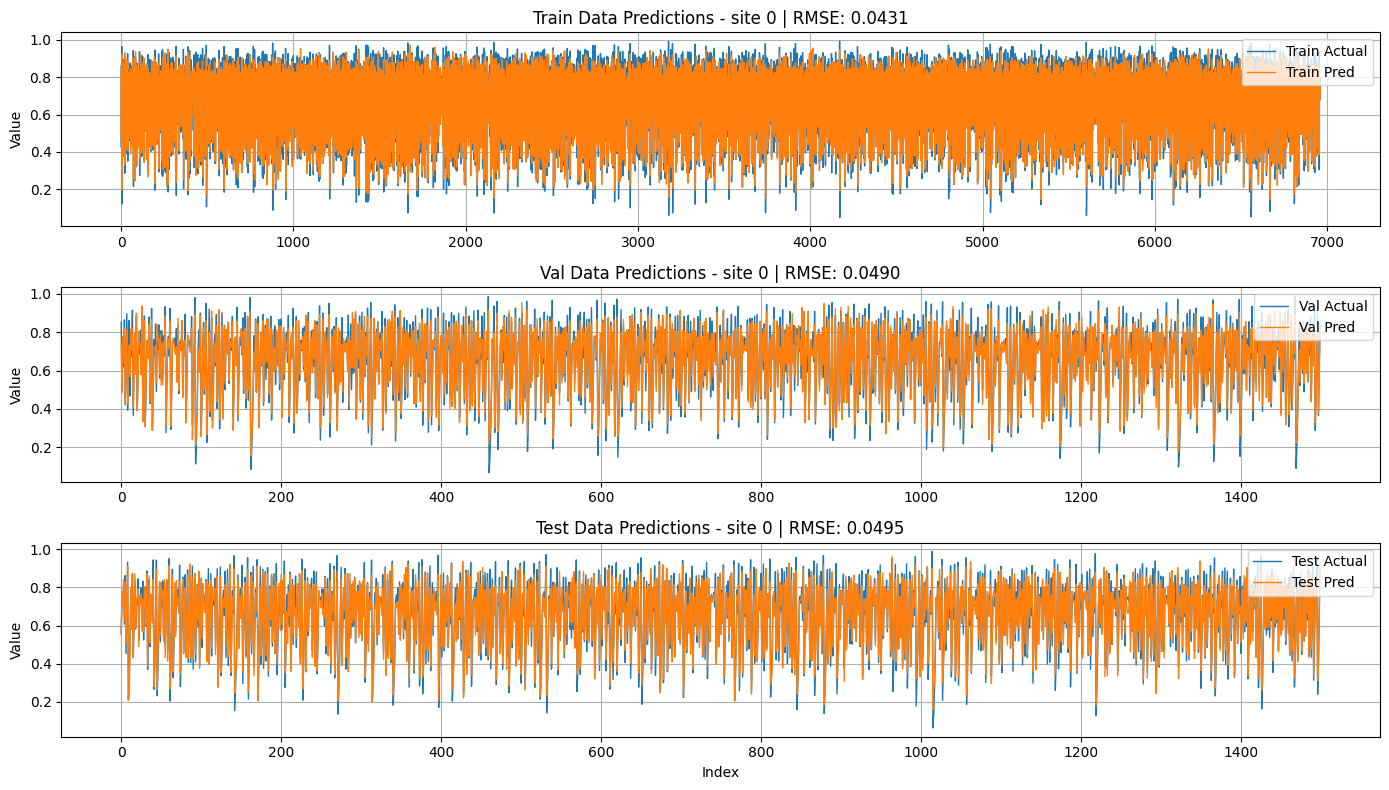

In [6]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.nn.init as init
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import os

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


class ChebySigmoid(nn.Module):
    def __init__(self, alpha=1.0, beta=1.0, n=1.0):
        super().__init__()
        self.alpha = alpha
        self.beta = beta
        self.n = n

    def forward(self, x):
        s = torch.sigmoid(x)
        tb = torch.tanh(self.beta * x)
        tb = torch.clamp(tb, -1 + 1e-6, 1 - 1e-6)
        return s + self.alpha * torch.cos(self.n * torch.acos(tb)) * s * (1 - s)


class ChebyTanh(nn.Module):
    def __init__(self, alpha=1.0, beta=1.0, n=1.0):
        super().__init__()
        self.alpha = alpha
        self.beta = beta
        self.n = n

    def forward(self, x):
        tb = torch.tanh(self.beta * x)
        tb = torch.clamp(tb, -1 + 1e-6, 1 - 1e-6)
        t = torch.tanh(x)
        sech2 = (1.0 / torch.cosh(x)) ** 2
        return t + self.alpha * torch.cos(self.n * torch.acos(tb)) * sech2


class ChebyLSTMCell(nn.Module):
    def __init__(self, input_size, hidden_size, alpha=1.0, beta=1.0, n=1.0):
        super().__init__()
        self.hidden_size = hidden_size
        self.w_ih = nn.Parameter(torch.empty(4 * hidden_size, input_size))
        self.w_hh = nn.Parameter(torch.empty(4 * hidden_size, hidden_size))
        self.b_ih = nn.Parameter(torch.zeros(4 * hidden_size))
        self.b_hh = nn.Parameter(torch.zeros(4 * hidden_size))
        self.sig_act = ChebySigmoid(alpha, beta, n)
        self.tanh_act = ChebyTanh(alpha, beta, n)
        init.xavier_uniform_(self.w_ih)
        init.xavier_uniform_(self.w_hh)

    def forward(self, x_t, state):
        h, c = state
        gates = F.linear(x_t, self.w_ih, self.b_ih) + F.linear(h, self.w_hh, self.b_hh)
        i, f, g, o = gates.chunk(4, dim=1)
        i = self.sig_act(i)
        f = self.sig_act(f)
        g = self.tanh_act(g)
        o = self.sig_act(o)
        c_next = f * c + i * g
        h_next = o * self.tanh_act(c_next)
        return h_next, (h_next, c_next)


class ChebyLSTM(nn.Module):
    def __init__(self, input_size, hidden_size=32, output_size=None, alpha=1.0, beta=1.0, n=1.0):
        super().__init__()
        if output_size is None:
            output_size = input_size
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.cell = ChebyLSTMCell(input_size, hidden_size, alpha, beta, n)
        self.fc = nn.Linear(hidden_size, output_size)
        init.xavier_uniform_(self.fc.weight)
        if self.fc.bias is not None:
            init.constant_(self.fc.bias, 0.0)

    def forward(self, x):
        x = x.transpose(0, 1)
        b = x.size(1)
        h = torch.zeros(b, self.hidden_size, device=x.device)
        c = torch.zeros(b, self.hidden_size, device=x.device)
        for t in range(x.size(0)):
            h, (h, c) = self.cell(x[t], (h, c))
        y = self.fc(h)
        return y


def load_coupled_series(csv_path):
    df = pd.read_csv(csv_path)
    if "step" in df.columns:
        df = df.drop(columns=["step"])
    num_df = df.select_dtypes(include=[np.number])
    data = num_df.values.astype(np.float32)
    return data


def make_supervised_multi(data, seq_len):
    T, D = data.shape
    N = T - seq_len
    X = np.zeros((N, seq_len, D), dtype=np.float32)
    Y = np.zeros((N, D), dtype=np.float32)
    for i in range(N):
        X[i] = data[i:i + seq_len]
        Y[i] = data[i + seq_len]
    return X, Y


def prepare_loaders_multi(data, seq_len=20, split=0.7, val_split=0.15, batch=64):
    T = data.shape[0]
    train_end = int(T * split)
    val_end = int(T * (split + val_split))
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler.fit(data[:train_end])
    data_scaled = scaler.transform(data)
    X, Y = make_supervised_multi(data_scaled, seq_len)
    train_N = train_end - seq_len
    val_N = val_end - seq_len
    train_X_np = X[:train_N]
    train_Y_np = Y[:train_N]
    val_X_np = X[train_N:val_N]
    val_Y_np = Y[train_N:val_N]
    test_X_np = X[val_N:]
    test_Y_np = Y[val_N:]
    train_ds = TensorDataset(
        torch.tensor(train_X_np, dtype=torch.float32, device=device),
        torch.tensor(train_Y_np, dtype=torch.float32, device=device)
    )
    val_ds = TensorDataset(
        torch.tensor(val_X_np, dtype=torch.float32, device=device),
        torch.tensor(val_Y_np, dtype=torch.float32, device=device)
    )
    test_ds = TensorDataset(
        torch.tensor(test_X_np, dtype=torch.float32, device=device),
        torch.tensor(test_Y_np, dtype=torch.float32, device=device)
    )
    train_loader = DataLoader(train_ds, batch_size=batch, shuffle=True, drop_last=True)
    val_loader = DataLoader(val_ds, batch_size=batch, shuffle=False, drop_last=False)
    test_loader = DataLoader(test_ds, batch_size=batch, shuffle=False, drop_last=False)
    return (
        train_loader,
        val_loader,
        test_loader,
        scaler,
        train_X_np,
        train_Y_np,
        val_X_np,
        val_Y_np,
        test_X_np,
        test_Y_np,
        data_scaled
    )


def train_once(model, train_loader, val_loader, epochs=10, lr=1e-3):
    model = model.to(device)
    opt = optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.MSELoss()
    train_losses = []
    val_losses = []
    for ep in range(epochs):
        model.train()
        total = 0.0
        for xb, yb in train_loader:
            opt.zero_grad()
            yhat = model(xb)
            loss = loss_fn(yhat, yb)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
            opt.step()
            total += loss.item() * xb.size(0)
        avg_tr = total / len(train_loader.dataset)
        model.eval()
        tot_val = 0.0
        with torch.no_grad():
            for xb, yb in val_loader:
                yhat = model(xb)
                l = loss_fn(yhat, yb)
                tot_val += l.item() * xb.size(0)
        avg_val = tot_val / max(1, len(val_loader.dataset))
        train_losses.append(avg_tr)
        val_losses.append(avg_val)
        print("epoch", ep + 1, "train", avg_tr, "val", avg_val)
    return model, train_losses, val_losses


def wasserstein_distance_1d(u, v):
    u = np.sort(u.ravel())
    v = np.sort(v.ravel())
    n = u.size
    m = v.size
    i = j = 0
    cdf_u = 0.0
    cdf_v = 0.0
    prev_x = min(u[0], v[0])
    wd = 0.0
    while i < n and j < m:
        if u[i] <= v[j]:
            x = u[i]
            i += 1
            cdf_u = i / n
        else:
            x = v[j]
            j += 1
            cdf_v = j / m
        wd += abs(cdf_u - cdf_v) * (x - prev_x)
        prev_x = x
    while i < n:
        x = u[i]
        i += 1
        cdf_u = i / n
        wd += abs(cdf_u - cdf_v) * (x - prev_x)
        prev_x = x
    while j < m:
        x = v[j]
        j += 1
        cdf_v = j / m
        wd += abs(cdf_u - cdf_v) * (x - prev_x)
        prev_x = x
    return float(wd)


def evaluate_rmse_wasserstein(model, X, Y, scaler):
    model.eval()
    X_t = torch.tensor(X, dtype=torch.float32, device=device)
    with torch.no_grad():
        pred = model(X_t).cpu().numpy()
    pred_inv = scaler.inverse_transform(pred)
    true_inv = scaler.inverse_transform(Y)
    rmse = float(np.sqrt(np.mean((pred_inv - true_inv) ** 2)))
    D = true_inv.shape[1]
    ws_per_site = []
    for d in range(D):
        ws_d = wasserstein_distance_1d(true_inv[:, d], pred_inv[:, d])
        ws_per_site.append(ws_d)
    ws_per_site = np.array(ws_per_site, dtype=np.float64)
    ws_mean = float(ws_per_site.mean())
    return true_inv, pred_inv, rmse, ws_mean, ws_per_site


def plot_site_predictions(site_index, train_true, train_pred, val_true, val_pred, test_true, test_pred, train_rmse, val_rmse, test_rmse):
    fig, axes = plt.subplots(3, 1, figsize=(14, 8), sharex=False)
    axes[0].plot(train_true[:, site_index], linewidth=1, label="Train Actual")
    axes[0].plot(train_pred[:, site_index], linewidth=1, label="Train Pred")
    axes[0].set_title(f"Train Data Predictions - site {site_index} | RMSE: {train_rmse:.4f}")
    axes[0].set_ylabel("Value")
    axes[0].grid(True)
    axes[0].legend(loc="upper right")
    axes[1].plot(val_true[:, site_index], linewidth=1, label="Val Actual")
    axes[1].plot(val_pred[:, site_index], linewidth=1, label="Val Pred")
    axes[1].set_title(f"Val Data Predictions - site {site_index} | RMSE: {val_rmse:.4f}")
    axes[1].set_ylabel("Value")
    axes[1].grid(True)
    axes[1].legend(loc="upper right")
    axes[2].plot(test_true[:, site_index], linewidth=1, label="Test Actual")
    axes[2].plot(test_pred[:, site_index], linewidth=1, label="Test Pred")
    axes[2].set_title(f"Test Data Predictions - site {site_index} | RMSE: {test_rmse:.4f}")
    axes[2].set_xlabel("Index")
    axes[2].set_ylabel("Value")
    axes[2].grid(True)
    axes[2].legend(loc="upper right")
    plt.tight_layout()
    plt.show()


if __name__ == "__main__":
    csv_path = "coupled_tent_1d.csv"
    if not os.path.exists(csv_path):
        print("csv not found")
        raise SystemExit(1)

    raw_data = load_coupled_series(csv_path)

    alpha = 0.558532
    beta = 1.496159
    n = 3.463616
    hidden_size = 256
    seq_len = 40

    (
        train_loader,
        val_loader,
        test_loader,
        scaler,
        Xtr,
        Ytr,
        Xval,
        Yval,
        Xte,
        Yte,
        data_scaled
    ) = prepare_loaders_multi(
        raw_data,
        seq_len=seq_len,
        split=0.7,
        val_split=0.15,
        batch=64,
    )

    input_size = raw_data.shape[1]

    final_model = ChebyLSTM(
        input_size=input_size,
        hidden_size=hidden_size,
        output_size=input_size,
        alpha=alpha,
        beta=beta,
        n=n,
    )

    final_model, train_losses, val_losses = train_once(
        final_model,
        train_loader,
        val_loader,
        epochs=10,
        lr=1e-3,
    )

    train_true, train_pred, train_rmse, train_ws_mean, train_ws_sites = evaluate_rmse_wasserstein(final_model, Xtr, Ytr, scaler)
    val_true, val_pred, val_rmse, val_ws_mean, val_ws_sites = evaluate_rmse_wasserstein(final_model, Xval, Yval, scaler)
    test_true, test_pred, test_rmse, test_ws_mean, test_ws_sites = evaluate_rmse_wasserstein(final_model, Xte, Yte, scaler)

    print("Final metrics:")
    print("Train  RMSE:", train_rmse, "W1_mean:", train_ws_mean)
    print("Val    RMSE:", val_rmse,  "W1_mean:", val_ws_mean)
    print("Test   RMSE:", test_rmse, "W1_mean:", test_ws_mean)

    plot_site_predictions(
        site_index=0,
        train_true=train_true,
        train_pred=train_pred,
        val_true=val_true,
        val_pred=val_pred,
        test_true=test_true,
        test_pred=test_pred,
        train_rmse=train_rmse,
        val_rmse=val_rmse,
        test_rmse=test_rmse,
    )
